In [18]:
from atmPy import sizedistribution
from atmPy.instruments.DMA import smps
from atmPy.instruments.DMA import dma
import matplotlib.pyplot as plt
import atmPy.aerosol as aerosol
import atmPy.atmosphere as atm
import numpy as np
import pandas as pd

%matplotlib inline

# Demonstration of DMA Calculations

The ``DMA`` is represented as a single object in the code.  The object consists of three attributes: ``_ro``, ``_ri`` and ``_l``, the dimensions of the DMA (outer and inner radius - $r_o$ and $r_i$ as well as length $l$).  These parameters are considered to be "private" and are defined by the children although the class can be used directly by setting these directly.

The DMA object contains one method: ``v2d``.  This method calculates the diameter of a size selected particle as a function of voltage, atmospheric conditions and flow rates.

``` python
def v2d(self, v, gas, qc, qm):
        """
        Find selected diameter at a given voltage.
        
        This function uses a Newton-Raphson root finder to solve for the 
        diameter of the particle.
        
        Parameters
        ----------
        v:      float
                Voltage in Volts
        gas:    gas object
                Carrier gas object for performing calculations
        qc:     float
                Input sheath flow in lpm
        qm:     float
                Output sheath flow in lpm
        
        Returns
        -------
        Diameter in nanometers
    
        """
        gamma = self._l/log(self._ro/self._ri)

        # Convert flow rates from lpm to m3/s
        qc = float(qc)/60*0.001
        qm = float(qm)/60*0.001
        
        # Central mobility
        zc = (qc+qm)/(4*pi*gamma*v)
        return newton(lambda d: z(d, gas, 1)-zc, 1, maxiter=1000)
```

This method uses a Newton-Raphson zero finding routine to determine the diameter associated with central mobility.

## Using the DMA Class

The following code demonstrates how to use the DMA class that is found in the ``atmPy`` package.

In [21]:
# Instantiate a DMA object based on the NOAA wide DMA dimensions
noaa = dma.NoaaWide()

# We also need a gas object that will represent the carrier gas of interest: air
air = atm.Air()

# Set the conditions to something representative of the conditions in the Boulder DMA
air.t = 23
air.p = 820

d = noaa.v2d(50, air, 5, 5)

print('The diameter associated with a 5 lpm flow and 50 V is ' + str(d) + ' nm.')

The diameter associated with a 5 lpm flow and 50 V is 49.7500677677439 nm.


# Generating a Simulation Size Distribution

In order to test the SMPS inversion, we need to simulate some type of size distribution

Generate a size distribution that we can use to test the retrieval of the SMPS data.  We will put the geometric mean (```dg```) at 60 nm, close to the observed point during HAGiS.

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


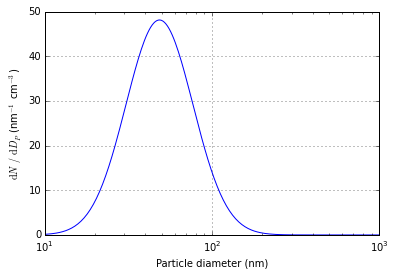

In [2]:
sd = sizedistribution.simulate_sizedistribution(d=[10, 2000],
                                                ndp=250, 
                                                dg=60, 
                                                sg=0.2, 
                                                nmode=3000)
f,a = sd.plot()
a.set_xlim([10,1000])
a.grid()


Now, we need to transform the size distribution so that it is what the SMPS might observe.

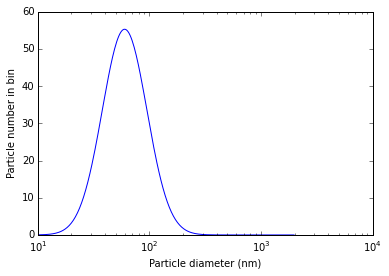

In [3]:
nd = sd.convert2numberconcentration()
f,a = nd.plot()

Now, we need to "correct" the size distribution so that it is what the SMPS would observe:

1. Starting at the bottom-most bin, calculate the number of singly charged particles in the bin.  This will be the base number of particles in the bin.
2. Based on the total number of particles, calculate the number of multiply charged particles expected as well as the diameters where they would reside.
3. If the diameter of the multiply charged particles is greater than the min, place that number in the nearest diameter bin.


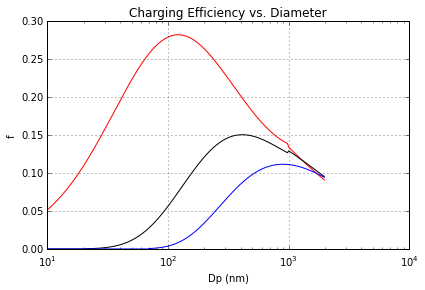

In [4]:
# demonstrate charing efficiency on size distribution
f2 = [aerosol.ndistr(i,n=-2,t=20) for i in nd.bincenters]
f3 = [aerosol.ndistr(i,n=-3,t=20) for i in nd.bincenters]
f1 = [aerosol.ndistr(i,n=-1,t=20) for i in nd.bincenters]
fig,ax = plt.subplots()

ax.plot(nd.bincenters, f1, 'r', nd.bincenters, f2,'k',  nd.bincenters, f3, 'b')
ax.set_xscale('log')
ax.set_xlabel('Dp (nm)')
ax.set_ylabel('f')
ax.grid()
fig.tight_layout()
ax.set_title('Charging Efficiency vs. Diameter')

In [5]:
# Create an air object of aerosl calculations...
air = atm.Air()
air.t = 20
air.p = 850

# Validate vs. Paul Barron's calculations; LOOKS GOOD
aerosol.z(1000, air, 1)

1.0963556340099868e-09

In [6]:


# Define a function for finding the diameter
fmin = lambda dm: (np.abs(nd.bincenters - dm)).argmin()

xd = nd.copy()

for i,n in enumerate(xd.data.iloc[0,:].values):
    f1 = aerosol.ndistr(xd.bincenters[i],n=-1,t = air.t)
    f2 = aerosol.ndistr(xd.bincenters[i],n=-2,t = air.t)
    f3 = aerosol.ndistr(xd.bincenters[i],n=-3,t = air.t)
    
    d2 =aerosol.z2d(aerosol.z(xd.bincenters[i],air, n=2),air, n=1) 
    if d2>= xd.bins[0]:
        k = fmin(d2)
        if d2 > xd.bins[k]:
            xd.data.values[0,k] += f2*n
        else:
            xd.data.values[0,k-1] +=f2*n
    
    d3 =aerosol.z2d(aerosol.z(xd.bincenters[i],air, n=3),air, n=1) 
    if d3>= xd.bins[0]:
        k = fmin(d3)
        if d3 > xd.bins[k]:
            xd.data.values[0,k] += f3*n
        else:
            xd.data.values[0,k-1] +=f3*n
    
    xd.data.values[0,i] = f1*n   
    # print([i, xd.bincenters[i], fmin(d2), d2, fmin(d3), d3])
        

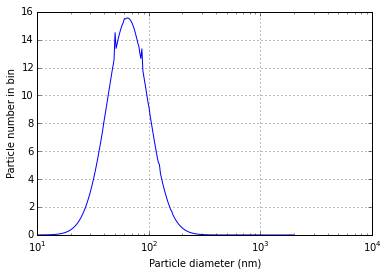

In [7]:
f,a = xd.plot()
a.grid()


**So there is some funniness in the discreet nature of the problem - **the reason the discreet peaks appear is that the algorithm is dumping multiples of multiples into a single bin.  I have tried to address this by dumping the data into the bins with a fixed bin width (rather than searching for the nearest bin center), but to no avail.  The problem is exacerbated by increasing the granularity of the problem (the opposite of what I thought might happen).  

At this point, I will just move ahead and hope that I get this right...


In [8]:
# The SMPS routines need a mean data dataframe with the following entries
mean_data = {"Sh_Q_VLPM":3.9, "Aer_Temp_C": air.t, "Aer_Pres_PSI":air.p, "Aer_Q_VLPM":0.39
    }

# Convert the dict to a list and generate a dataframe
df = pd.DataFrame([mean_data])

In [9]:
# Create a new SMPS object using the dimensions of the NOAA Wide DMA...
tSMPS = smps.SMPS(dma.NoaaWide())

In [10]:
xd.data.iloc[0,:].values

array([  1.62566215e-03,   1.99051983e-03,   2.43189139e-03,
         2.96457059e-03,   3.60593488e-03,   4.37633885e-03,
         5.29955619e-03,   6.40327396e-03,   7.71964302e-03,
         9.28588799e-03,   1.11449800e-02,   1.33463750e-02,
         1.59468199e-02,   1.90112269e-02,   2.26136188e-02,
         2.68381406e-02,   3.25820523e-02,   3.85593564e-02,
         4.55330638e-02,   5.36497564e-02,   6.30739938e-02,
         7.39898942e-02,   8.66027477e-02,   1.01140643e-01,
         1.17856084e-01,   1.37027566e-01,   1.58961083e-01,
         1.83991524e-01,   2.12483924e-01,   2.44834519e-01,
         2.81471555e-01,   3.22855804e-01,   3.69480724e-01,
         4.21872207e-01,   4.80587857e-01,   5.46215739e-01,
         6.19372530e-01,   7.00701029e-01,   7.90866965e-01,
         8.90555056e-01,   1.00046428e+00,   1.12130235e+00,
         1.25377929e+00,   1.39860029e+00,   1.55645759e+00,
         1.72802167e+00,   1.91393165e+00,   2.11478499e+00,
         2.33112657e+00,

In [11]:
dndlogdp = tSMPS.__fwhm__(xd.bincenters, xd.data.iloc[0,:].values, df)

In [12]:
dndlogdp[-1] = 0

In [13]:
xd.data.iloc[0,:].values

array([  3.12245335e-02,   3.72944010e-02,   4.44492175e-02,
         5.28636823e-02,   6.27369656e-02,   7.42954837e-02,
         8.77958780e-02,   1.03528196e-01,   1.21819264e-01,
         1.43036246e-01,   1.67590364e-01,   1.95940761e-01,
         2.28598483e-01,   2.66130533e-01,   3.09163967e-01,
         3.58389969e-01,   4.14573214e-01,   4.78535287e-01,
         5.51187580e-01,   6.33516164e-01,   7.26588709e-01,
         8.31557756e-01,   9.49661725e-01,   1.08222674e+00,
         1.23066670e+00,   1.39648152e+00,   1.58125822e+00,
         1.78666518e+00,   2.01444920e+00,   2.26643132e+00,
         2.54139399e+00,   2.84894868e+00,   3.18492678e+00,
         3.55294822e+00,   3.95501530e+00,   4.39321519e+00,
         4.86954282e+00,   5.38604859e+00,   5.94460942e+00,
         6.54711523e+00,   7.19528910e+00,   7.89072816e+00,
         8.63502853e+00,   9.42933090e+00,   1.02747307e+01,
         1.11720450e+01,   1.21216351e+01,   1.34154442e+01,
         1.43203270e+01,

(<matplotlib.figure.Figure at 0xce587b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0xcd0a5c0>)

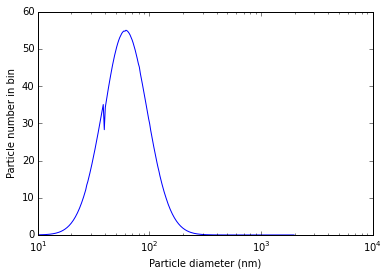

In [14]:
xd.plot()

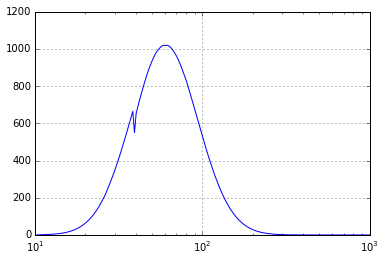

In [15]:
fig, ax= plt.subplots()
ax.plot(tSMPS.diam_interp, dndlogdp)
ax.set_xscale('log')
ax.grid()

In [16]:
noaa = dma.NoaaWide()
air = atm.Air()

In [17]:
air.t = 25
air.p = 820
noaa.v2d(37.2, air, 3.7, 3.7)

49.752418885513265